In [21]:
from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

%matplotlib inline

    
def convert_eval(text):
    if text == 'prior':
        return 0
    elif text == 'train':
        return 1
    elif text == 'test': 
        return 2
    else:
        return text
    
def convert_order_gap(value):
    if value >= 30:
        return np.random.randint(30, 60)
    else:
        return value
    
#adds classes based on reorder rates
def convert_reorder_class(value):
    if value >= .5:
        return 2
    else:
        return 1
    

#adds classes for avg cart size 
def convert_class_cart(value):
    if value <= 6.5:
        return 3
    elif value <= 11.5:
        return 4
    else:
        return 5
#adjusting the streak counts to account for the first order, which has 0 reorders
def adjust_streak(value):
    if value > 0:
        return value+1
    else:
        return value
    
def get_streak_count(dataframe, column, streak):
    df = dataframe[dataframe[column] == streak].drop('product_id', 1).groupby('user_id').count().reset_index()
    df = df.rename(columns = {column: str(streak)+'_streak'})
    return df


def resamplingv2(df, column, classname):
    m = max(df[column].value_counts())
    class_df = df[df[column] == classname]
    rest_df = df[df[column] != classname]
    if len(class_df[column]) < m:
        random_index = np.random.choice(class_df.index, m, replace = True)
        rest_df = rest_df.append(class_df.loc[random_index])
        return rest_df
    else:
        return rest_df.append(class_df)
    
pd.set_option("display.max_rows",20)

In [19]:
df_orders = pd.read_csv('data/orders.csv')
df_aisle = pd.read_csv('data/aisles.csv')
#list of the aisles - diff of aisles & depts?
df_dept = pd.read_csv('data/departments.csv')
#list of the departments
df_prod = pd.read_csv('data/products.csv')
#list of all the products
df_order_prior = pd.read_csv('data/order_products__prior.csv')
#all prior orders; dataframe is massive
df_order_train = pd.read_csv('data/order_products__prior.csv')
#training set

Creating a master document with all the product data

In [20]:
df_goods= pd.merge(left=pd.merge(left=df_prod, right=df_dept, how='left'), right = df_aisle, how = 'left')

df_goods.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [21]:
df_orders['eval_set'] = df_orders['eval_set'].apply(lambda x: convert_eval(x))

In [22]:
df_order_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


Let's see count of orders represented in the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11997ef048>]], dtype=object)

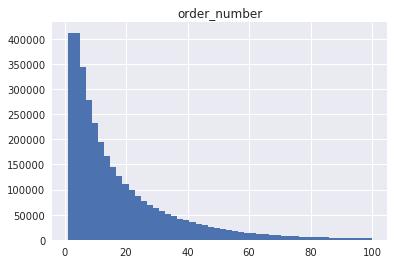

In [23]:
df_orders.hist('order_number', bins = 50)

It looks like if I want to use Order Number, I'll have to do a log transformation since it decreases exponentially. They also cap it at the hundredth order.  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11963ef5c0>]], dtype=object)

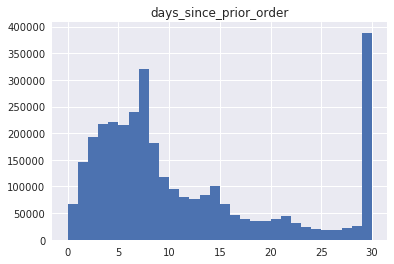

In [24]:
plt.figure(figsize = (12,9))
df_orders.hist('days_since_prior_order', bins = 30)


We see spikes of orders at 7 days (weekly) and after 30 days. They aggregate anything over 30 days so I should spread this data out eventually 

In [25]:
df_all = pd.merge(df_order_prior, df_goods, 
                  on = ['product_id', 'product_id'])
df_all = df_all.merge(df_orders,on= 'order_id')


In [26]:
df_all['days_since_prior_order'] = df_all['days_since_prior_order'].apply(lambda x: convert_order_gap(x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11961f32b0>]], dtype=object)

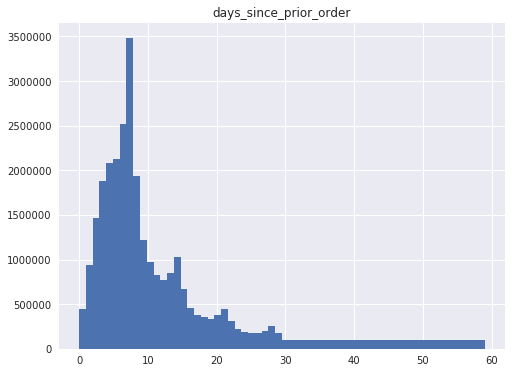

In [27]:
df_all.hist('days_since_prior_order', bins = 60, figsize = (8,6))

That looks a lot better

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11961d19b0>]], dtype=object)

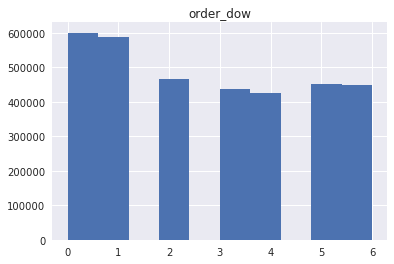

In [28]:
df_orders.hist('order_dow')


It looks like there's more orders on the first 2 days of the week - Monday and Tues

In [29]:
top_repeats = df_order_prior.groupby('product_id').reordered.sum().reset_index()

In [30]:
top_repeats = top_repeats.merge(df_goods, on = 'product_id', how = 'right').sort_values('reordered', ascending = False)

In [31]:
top_repeats.head(20)

,product_id,reordered,product_name,aisle_id,department_id,department,aisle
24848,24852,398609.0,Banana,24,4,produce,fresh fruits
13172,13176,315913.0,Bag of Organic Bananas,24,4,produce,fresh fruits
21133,21137,205845.0,Organic Strawberries,24,4,produce,fresh fruits
21899,21903,186884.0,Organic Baby Spinach,123,4,produce,packaged vegetables fruits
47198,47209,170131.0,Organic Hass Avocado,24,4,produce,fresh fruits
47755,47766,134044.0,Organic Avocado,24,4,produce,fresh fruits
27839,27845,114510.0,Organic Whole Milk,84,16,dairy eggs,milk
47615,47626,106255.0,Large Lemon,24,4,produce,fresh fruits
27960,27966,105409.0,Organic Raspberries,123,4,produce,packaged vegetables fruits
16793,16797,99802.0,Strawberries,24,4,produce,fresh fruits


It looks like a lot of produce are ordered at high rates, especially bananas. 

In [32]:
df_all['reordered'] = df_all['reordered'].fillna(0)

In [33]:
df_all = df_all.drop(['aisle_id', 'department_id', 'eval_set'], 1)

In [34]:
#need to calculate average cart reorder and create a user list

df_carts = df_all.groupby("order_id")["reordered"].agg(["size","sum"]).reset_index()

In [35]:
df_carts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214874 entries, 0 to 3214873
Data columns (total 3 columns):
order_id    int64
size        int64
sum         int64
dtypes: int64(3)
memory usage: 73.6 MB


In [36]:
df_carts = df_carts.rename(columns={"size":"cart_size", "sum":"reorders"})
df_carts["reorder_percent"] = df_carts["reorders"]/df_carts["cart_size"]

In [37]:
df_orders = df_orders.merge(df_carts, on = ['order_id', 'order_id'])

df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cart_size,reorders,reorder_percent
0,2539329,1,0,1,2,8,NaN,5,0,0.000
1,2398795,1,0,2,3,7,15.0,6,3,0.500
2,473747,1,0,3,3,12,21.0,5,3,0.600
3,2254736,1,0,4,4,7,29.0,5,5,1.000
4,431534,1,0,5,4,15,28.0,8,5,0.625


In [38]:
df_five_orders = df_all.drop(df_all[df_all['order_number'] > 5].index)

In [39]:
df_five_cust_prod = pd.crosstab(df_five_orders['user_id'], df_five_orders['aisle'])


In [40]:
df_five_cust_prod= df_five_cust_prod.reset_index()

In [41]:
df_streak = df_five_orders.groupby(['user_id', 'product_id'])['reordered'].sum().reset_index()

In [42]:
df_streak[df_streak['user_id'] ==1]

,user_id,product_id,reordered
0,1,196,4
1,1,10258,3
2,1,10326,0
3,1,12427,4
4,1,13032,0
5,1,13176,1
6,1,14084,0
7,1,17122,0
8,1,25133,2
9,1,26088,1


In [43]:
df_streak['reordered'] = df_streak['reordered'].apply(lambda x: adjust_streak(x))

In [45]:
df_users_train = df_five_orders.drop(['product_id', 'add_to_cart_order', 
                               'reordered', 'product_name', 'department', 'aisle'], 1)
df_users_train = df_users_train.set_index('order_id')
df_users_train = df_users_train.drop_duplicates().sort_values('user_id').reset_index()
df_users_train = df_users_train.drop(['order_id'], 1)

Let's create average and standard deviate data based on time behaviors

In [46]:
weekdays = df_users_train.groupby('user_id')['order_dow'].agg(['mean', 'std']).reset_index()
hours = df_users_train.groupby('user_id')['order_hour_of_day'].agg(['mean', 'std']).reset_index()
order_gap = df_users_train.groupby('user_id')['days_since_prior_order'].agg(['mean', 'std']).reset_index()
weekdays = weekdays.rename(columns={"mean":"dow_mean", "std":"dow_std"})
hours = hours.rename(columns={"mean":"hour_mean", "std":"hour_std"})
order_gap = order_gap.rename(columns={"mean":"order_gap_mean", "std":"order_gap_std"})

df_users_train = df_users_train.drop(['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], 1)
df_users_train = df_users_train.merge(weekdays, on = ['user_id', 'user_id'])
df_users_train = df_users_train.merge(hours, on = ['user_id', 'user_id'])
df_users_train = df_users_train.merge(order_gap, on = ['user_id', 'user_id'])

df_users_train.head()

,user_id,dow_mean,dow_std,hour_mean,hour_std,order_gap_mean,order_gap_std
0,1,3.2,0.83666,9.8,3.563706,23.25,6.551081
1,1,3.2,0.83666,9.8,3.563706,23.25,6.551081
2,1,3.2,0.83666,9.8,3.563706,23.25,6.551081
3,1,3.2,0.83666,9.8,3.563706,23.25,6.551081
4,1,3.2,0.83666,9.8,3.563706,23.25,6.551081


In [47]:
df_users_train = df_users_train.drop_duplicates()


Let's look at order data now and create features around that

In [48]:
orders = df_five_orders.groupby('user_id')['order_number'].max().reset_index()
reorders = df_five_orders.groupby('user_id')['reordered'].agg(['size','sum']).reset_index()
reorders = reorders.rename(columns={"size":"total_products", "sum":"total_reorders"})

In [49]:
reorders = reorders.merge (orders, on = ['user_id', 'user_id'])
reorders['ttl_reorder_rate'] = reorders['total_reorders']/reorders ['total_products']
reorders['avg_cart'] = reorders['total_products']/reorders ['order_number']
reorders['avg_reorders'] = reorders['total_reorders']/reorders ['order_number']

df_users_train = df_users_train.merge(reorders, on = ['user_id', 'user_id'])
df_users_train.head()



,user_id,dow_mean,dow_std,hour_mean,hour_std,order_gap_mean,order_gap_std,total_products,total_reorders,order_number,ttl_reorder_rate,avg_cart,avg_reorders
0,1,3.20,0.836660,9.8,3.563706,23.250000,6.551081,29,16,5,0.551724,5.80,3.2
1,2,2.60,1.516575,10.4,0.547723,7.250000,2.986079,50,6,5,0.120000,10.00,1.2
2,3,1.80,1.303840,16.8,1.923538,15.500000,5.916080,41,14,5,0.341463,8.20,2.8
3,4,4.80,0.836660,12.6,1.673320,13.750000,9.500000,18,1,5,0.055556,3.60,0.2
4,5,1.75,1.500000,16.0,2.828427,13.333333,4.932883,37,14,4,0.378378,9.25,3.5


Let's add back in the aisle data 

In [50]:
df_users_train = df_users_train.merge(df_five_cust_prod, on = ['user_id', 'user_id'])

Let's add in the streak count data

In [51]:
df_users_train = df_users_train.merge(get_streak_count(df_streak, 'reordered', 5), 
                                       on = ['user_id', 'user_id'], how = 'left')
df_users_train = df_users_train.merge(get_streak_count(df_streak, 'reordered', 4), 
                                       on = ['user_id', 'user_id'], how = 'left')
df_users_train = df_users_train.merge(get_streak_count(df_streak, 'reordered', 3), 
                                        on = ['user_id', 'user_id'], how = 'left')
df_users_train = df_users_train.merge(get_streak_count(df_streak, 'reordered', 2),
                                        on = ['user_id', 'user_id'], how = 'left')
df_users_train = df_users_train.merge(get_streak_count(df_streak, 'reordered', 0), 
                                         on = ['user_id', 'user_id'], how = 'left')

df_users_train.head()

,user_id,dow_mean,dow_std,hour_mean,hour_std,order_gap_mean,order_gap_std,total_products,total_reorders,order_number,...,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,5_streak,4_streak,3_streak,2_streak,0_streak
0,1,3.20,0.836660,9.8,3.563706,23.250000,6.551081,29,16,5,...,0,0,0,0,0,2.0,1.0,1.0,3.0,6.0
1,2,2.60,1.516575,10.4,0.547723,7.250000,2.986079,50,6,5,...,0,0,0,0,3,NaN,1.0,1.0,1.0,41.0
2,3,1.80,1.303840,16.8,1.923538,15.500000,5.916080,41,14,5,...,0,0,1,0,0,NaN,1.0,4.0,3.0,19.0
3,4,4.80,0.836660,12.6,1.673320,13.750000,9.500000,18,1,5,...,0,0,1,0,0,NaN,NaN,NaN,1.0,16.0
4,5,1.75,1.500000,16.0,2.828427,13.333333,4.932883,37,14,4,...,0,0,0,0,3,NaN,2.0,2.0,4.0,15.0


In [52]:
df_users_train['class'] = df_users_train['ttl_reorder_rate'].apply(lambda x: convert_reorder_class(x))

In [53]:
df_users_train.fillna(0, inplace = True)

In [54]:
df_users_train['5_reorder_ratio'] = df_users_train['5_streak']*5/df_users_train['total_products']
df_users_train['4_reorder_ratio'] = df_users_train['4_streak']*4/df_users_train['total_products']
df_users_train['3_reorder_ratio'] = df_users_train['3_streak']*3/df_users_train['total_products']
df_users_train['2_reorder_ratio'] = df_users_train['4_streak']*2/df_users_train['total_products']
df_users_train['0_reorder_ratio'] = df_users_train['0_streak']/df_users_train['total_products']

In [55]:
df_users_train['cart_size_class'] = df_users_train['avg_cart'].apply(lambda x: convert_class_cart(x))
df_users_train = df_users_train.rename(columns = {'class': 'reorder_class'})
df_users_train['current_class'] = df_users_train['cart_size_class']  * df_users_train['reorder_class']

df_users_train.head()

,user_id,dow_mean,dow_std,hour_mean,hour_std,order_gap_mean,order_gap_std,total_products,total_reorders,order_number,...,2_streak,0_streak,reorder_class,5_reorder_ratio,4_reorder_ratio,3_reorder_ratio,2_reorder_ratio,0_reorder_ratio,cart_size_class,current_class
0,1,3.20,0.836660,9.8,3.563706,23.250000,6.551081,29,16,5,...,3.0,6.0,2,0.344828,0.137931,0.103448,0.068966,0.206897,3,6
1,2,2.60,1.516575,10.4,0.547723,7.250000,2.986079,50,6,5,...,1.0,41.0,1,0.000000,0.080000,0.060000,0.040000,0.820000,4,4
2,3,1.80,1.303840,16.8,1.923538,15.500000,5.916080,41,14,5,...,3.0,19.0,1,0.000000,0.097561,0.292683,0.048780,0.463415,4,4
3,4,4.80,0.836660,12.6,1.673320,13.750000,9.500000,18,1,5,...,1.0,16.0,1,0.000000,0.000000,0.000000,0.000000,0.888889,3,3
4,5,1.75,1.500000,16.0,2.828427,13.333333,4.932883,37,14,4,...,4.0,15.0,1,0.000000,0.216216,0.162162,0.108108,0.405405,4,4


In [56]:
df_users_train = df_users_train.drop('order_number', 1)

In [57]:
df_users_train['log_avg_cart'] = df_users_train['avg_cart'].apply(lambda x: np.log(x))
df_users_train['log_total_products'] = df_users_train['total_products'].apply(lambda x: np.log(x))

Let's calculate the dependent variable, which is future reorder behaviors

In [58]:
df_six_ten = df_all[df_all['order_number'] >=6]
df_six_ten = df_six_ten.drop(df_six_ten[df_six_ten['order_number'] >10].index)


In [59]:
y6classes = df_six_ten.groupby('user_id')['reordered'].agg(['size','sum']).reset_index()
y6classes = y6classes.rename(columns={"size":"total_products", "sum":"total_reorders"})
order_ct = df_six_ten.groupby('user_id')['order_number'].max().reset_index()
y6classes = y6classes.merge(order_ct, on = ['user_id', 'user_id'], how = 'left')
y6classes['reorder_rate'] = y6classes['total_reorders']/y6classes['total_products']
y6classes['avg_cart'] = y6classes['total_products']/(y6classes['order_number']-5)
y6classes.head()

,user_id,total_products,total_reorders,order_number,reorder_rate,avg_cart
0,1,30,25,10,0.833333,6.0
1,2,86,54,10,0.627907,17.2
2,3,36,30,10,0.833333,7.2
3,7,29,28,10,0.965517,5.8
4,11,32,10,7,0.312500,16.0


In [60]:
y6classes['cart_size_class'] = y6classes['avg_cart'].apply(lambda x: convert_class_cart(x))
y6classes['reorder_class'] = y6classes['reorder_rate'].apply(lambda x: convert_reorder_class(x))
y6classes['future_class'] = y6classes['reorder_class']  * y6classes['cart_size_class']

In [61]:
class_map = { 3: 'low_reorder_low_avg_cart', 4: 'low_reorder_medium_avg_cart',  5: 'low_reorder_large_avg_cart', 
             6: 'high_reorder_low_avg_cart', 8: 'high_reorder_medium_avg_cart',  10: 'high_reorder_large_avg_cart'}    

y6classes['future_class']= y6classes['future_class'].map(class_map)
ynewclass = y6classes[['user_id','future_class']]

Let's look at the distribution of the classes to see if there's any major imbalance. We have a lot more for high reorder users than other, so might have to upsample for the rest.

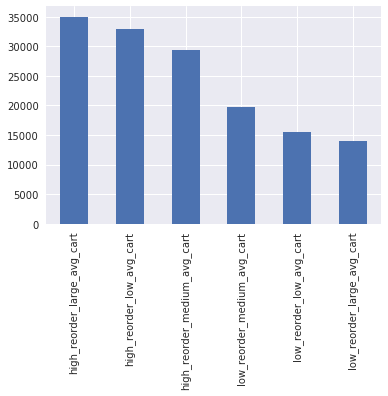

In [62]:
classes = ynewclass['future_class'].value_counts()
classes.plot( kind = 'bar');



In [64]:
df_set = df_users_train.merge(ynewclass, on = 'user_id')
X_train, X_test, y_train, y_test = train_test_split(df_set.drop(['future_class'], 1)
                                                    , df_set['future_class'], train_size = .3)

In [65]:
log = LogisticRegression()
log.fit(X_train, y_train)
print(accuracy_score(y_test, log.predict(X_test)))
print(classification_report(y_test, log.predict(X_test)))

0.478366885144
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.56      0.84      0.68     24336
   high_reorder_low_avg_cart       0.48      0.79      0.60     23039
high_reorder_medium_avg_cart       0.39      0.20      0.26     20588
  low_reorder_large_avg_cart       0.39      0.10      0.16      9894
    low_reorder_low_avg_cart       0.56      0.01      0.01     10781
 low_reorder_medium_avg_cart       0.34      0.37      0.36     13890

                 avg / total       0.46      0.48      0.41    102528



Let's try scaling the data

In [6]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(df_set.drop(['future_class'], 1))

Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, 
                                                        df_set['future_class'], train_size = .3, random_state = 444)
logs = LogisticRegression()
logs.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, logs.predict(Xs_test)))
print(classification_report(ys_test, logs.predict(Xs_test)))
                                   

0.518346207865
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.65      0.75      0.69     24525
   high_reorder_low_avg_cart       0.59      0.66      0.62     23074
high_reorder_medium_avg_cart       0.41      0.49      0.45     20389
  low_reorder_large_avg_cart       0.40      0.17      0.24      9851
    low_reorder_low_avg_cart       0.47      0.28      0.35     10865
 low_reorder_medium_avg_cart       0.36      0.34      0.35     13824

                 avg / total       0.51      0.52      0.50    102528



Looks like scaling worked well. I'm going to try resampling and rescaling

In [67]:
df_set3 = resamplingv2(df_set2, 'future_class', 'low_reorder_low_avg_cart')
df_set3 = resamplingv2(df_set3, 'future_class', 'high_reorder_medium_avg_cart')
df_set3 = resamplingv2(df_set3, 'future_class', 'high_reorder_large_avg_cart')
df_set3 = resamplingv2(df_set3, 'future_class', 'low_reorder_large_avg_cart')
df_set3 = resamplingv2(df_set3, 'future_class', 'low_reorder_medium_avg_cart')
df_set3 = resamplingv2(df_set3, 'future_class', 'high_reorder_low_avg_cart')

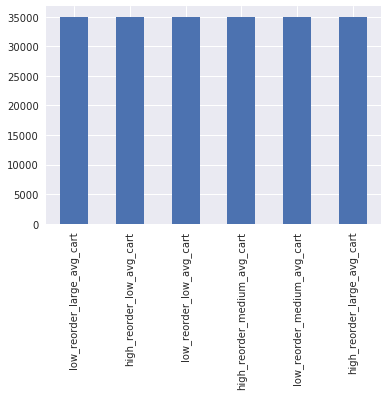

In [68]:
classes = df_set3['future_class'].value_counts()
classes.plot( kind = 'bar');

In [69]:

X2 = StandardScaler().fit_transform(df_set3.drop(['future_class'], 1))

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, df_set3['future_class'], 
                                                        train_size = .3, random_state = 444)

log2 = LogisticRegression()
log2.fit(X2_train, y2_train)
print(accuracy_score(y2_test, log2.predict(X2_test)))
print(classification_report(y2_test, log2.predict(X2_test)))

0.480957629194
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.61      0.65      0.62     24254
   high_reorder_low_avg_cart       0.54      0.51      0.53     24376
high_reorder_medium_avg_cart       0.41      0.44      0.43     24627
  low_reorder_large_avg_cart       0.46      0.41      0.43     24606
    low_reorder_low_avg_cart       0.51      0.51      0.51     24578
 low_reorder_medium_avg_cart       0.36      0.37      0.37     24547

                 avg / total       0.48      0.48      0.48    146988



That... didn't actually help. Let's try some other models with just the scaled data.

In [70]:
gau2 = GaussianNB()
gau2.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, gau2.predict(Xs_test)))
print(classification_report(ys_test, gau2.predict(Xs_test)))

0.432945146692
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.71      0.51      0.59     24525
   high_reorder_low_avg_cart       0.50      0.63      0.56     23074
high_reorder_medium_avg_cart       0.37      0.29      0.33     20389
  low_reorder_large_avg_cart       0.23      0.29      0.26      9851
    low_reorder_low_avg_cart       0.34      0.39      0.36     10865
 low_reorder_medium_avg_cart       0.29      0.30      0.29     13824

                 avg / total       0.45      0.43      0.44    102528



In [71]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, rfc.predict(Xs_test)))
print(classification_report(ys_test, rfc.predict(Xs_test)))

0.517185549313
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.64      0.75      0.69     24525
   high_reorder_low_avg_cart       0.59      0.66      0.62     23074
high_reorder_medium_avg_cart       0.42      0.48      0.45     20389
  low_reorder_large_avg_cart       0.38      0.19      0.26      9851
    low_reorder_low_avg_cart       0.46      0.27      0.34     10865
 low_reorder_medium_avg_cart       0.36      0.34      0.35     13824

                 avg / total       0.50      0.52      0.50    102528



In [72]:
abc = AdaBoostClassifier()
abc.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, abc.predict(Xs_test)))
print(classification_report(ys_test, abc.predict(Xs_test)))

0.514854478777
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.64      0.76      0.69     24525
   high_reorder_low_avg_cart       0.62      0.60      0.61     23074
high_reorder_medium_avg_cart       0.43      0.47      0.45     20389
  low_reorder_large_avg_cart       0.37      0.20      0.26      9851
    low_reorder_low_avg_cart       0.43      0.33      0.37     10865
 low_reorder_medium_avg_cart       0.35      0.38      0.36     13824

                 avg / total       0.50      0.51      0.51    102528



In [73]:
gbc = GradientBoostingClassifier()
gbc.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, gbc.predict(Xs_test)))
print(classification_report(ys_test, gbc.predict(Xs_test)))

0.52134051186
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.66      0.74      0.69     24525
   high_reorder_low_avg_cart       0.61      0.64      0.63     23074
high_reorder_medium_avg_cart       0.42      0.50      0.46     20389
  low_reorder_large_avg_cart       0.38      0.22      0.28      9851
    low_reorder_low_avg_cart       0.46      0.29      0.36     10865
 low_reorder_medium_avg_cart       0.36      0.37      0.36     13824

                 avg / total       0.51      0.52      0.51    102528



In [74]:
classes = [gbc, abc, rfc, gau2, logs]
for x in classes: 
    print(x, '\nAvg score:', np.mean(cross_val_score(x, X, df_set2['future_class'], cv = 5, n_jobs= 2)))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False) 
Avg score: 0.4211358506
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 
Avg score: 0.456572674189
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 
Avg sc

Let's try it with some adjusted class weights

In [75]:
weights = {'low_reorder_low_avg_cart':1, 'low_reorder_medium_avg_cart':2,  'low_reorder_large_avg_cart':3, 
             'high_reorder_low_avg_cart':1, 'high_reorder_medium_avg_cart':2, 'high_reorder_large_avg_cart': 3}  

In [ ]:
crange = [.01, .05, .1,.2,.5, 1, 2, 3,4,5,6,7,8,9,10]
  

param = dict(C =crange, class_weight = ['balanced', weights])

grid = GridSearchCV(logs, param, cv=5, scoring='accuracy')
grid.fit(X, df_set2['future_class'])

Best Parameters are C = .01 with class weights. Let's check out the f1 scores

In [76]:
logg = LogisticRegression(C = .01,class_weight = {'high_reorder_large_avg_cart': 3,
  'high_reorder_low_avg_cart': 1,
  'high_reorder_medium_avg_cart': 2,
  'low_reorder_large_avg_cart': 3,
  'low_reorder_low_avg_cart': 1,
  'low_reorder_medium_avg_cart': 2})
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, 
                                                        df_set2['future_class'], train_size = .3)
logg.fit(Xs_train,ys_train)
print(accuracy_score(ys_test, logg.predict(Xs_test)))
print(classification_report(ys_test, logg.predict(Xs_test)))

0.515127574906
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.63      0.78      0.70     24705
   high_reorder_low_avg_cart       0.64      0.59      0.61     22988
high_reorder_medium_avg_cart       0.42      0.49      0.45     20414
  low_reorder_large_avg_cart       0.36      0.23      0.28      9753
    low_reorder_low_avg_cart       0.54      0.18      0.27     10808
 low_reorder_medium_avg_cart       0.34      0.40      0.37     13860

                 avg / total       0.51      0.52      0.50    102528



In [11]:
logg2 = LogisticRegression(C = .01)

logg2.fit(Xs_train,ys_train)
print(accuracy_score(ys_test, logg2.predict(Xs_test)))
print(classification_report(ys_test, logg2.predict(Xs_test)))

0.518141385768
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.64      0.76      0.70     24525
   high_reorder_low_avg_cart       0.59      0.66      0.62     23074
high_reorder_medium_avg_cart       0.41      0.48      0.44     20389
  low_reorder_large_avg_cart       0.40      0.17      0.23      9851
    low_reorder_low_avg_cart       0.47      0.27      0.35     10865
 low_reorder_medium_avg_cart       0.36      0.35      0.35     13824

                 avg / total       0.50      0.52      0.50    102528



In [78]:
gridrf = joblib.load('gridrf') 

In [79]:
gridrf.grid_scores_


/home/leangers/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.48215, std: 0.00298, params: {'class_weight': 'balanced', 'n_estimators': 10},
 mean: 0.51201, std: 0.00257, params: {'class_weight': 'balanced', 'n_estimators': 50},
 mean: 0.51744, std: 0.00244, params: {'class_weight': 'balanced', 'n_estimators': 100},
 mean: 0.48390, std: 0.00380, params: {'class_weight': {'low_reorder_low_avg_cart': 1, 'low_reorder_medium_avg_cart': 2, 'low_reorder_large_avg_cart': 3, 'high_reorder_low_avg_cart': 1, 'high_reorder_medium_avg_cart': 2, 'high_reorder_large_avg_cart': 3}, 'n_estimators': 10},
 mean: 0.51200, std: 0.00226, params: {'class_weight': {'low_reorder_low_avg_cart': 1, 'low_reorder_medium_avg_cart': 2, 'low_reorder_large_avg_cart': 3, 'high_reorder_low_avg_cart': 1, 'high_reorder_medium_avg_cart': 2, 'high_reorder_large_avg_cart': 3}, 'n_estimators': 50},
 mean: 0.51726, std: 0.00202, params: {'class_weight': {'low_reorder_low_avg_cart': 1, 'low_reorder_medium_avg_cart': 2, 'low_reorder_large_avg_cart': 3, 'high_reorder_low_avg_cart'

In [8]:
RFC3 = RandomForestClassifier(n_estimators = 1000)
RFC3.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, RFC3.predict(Xs_test)))
print(classification_report(ys_test, RFC3.predict(Xs_test)))

0.520921114232
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.64      0.76      0.70     24525
   high_reorder_low_avg_cart       0.60      0.66      0.63     23074
high_reorder_medium_avg_cart       0.42      0.49      0.45     20389
  low_reorder_large_avg_cart       0.39      0.19      0.26      9851
    low_reorder_low_avg_cart       0.48      0.27      0.34     10865
 low_reorder_medium_avg_cart       0.36      0.36      0.36     13824

                 avg / total       0.51      0.52      0.51    102528



In [81]:
eclf = VotingClassifier(estimators=[('gbc', gbc), ('abc', abc), 
                                    ('gau', gau2), ('rfc', RFC3), ('log', logg2)], 
                        voting='hard')

eclf.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, eclf.predict(Xs_test)))
print(classification_report(ys_test, eclf.predict(Xs_test)))

0.523564294632
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.66      0.75      0.70     24705
   high_reorder_low_avg_cart       0.59      0.66      0.62     22988
high_reorder_medium_avg_cart       0.43      0.48      0.45     20414
  low_reorder_large_avg_cart       0.38      0.20      0.26      9753
    low_reorder_low_avg_cart       0.48      0.28      0.36     10808
 low_reorder_medium_avg_cart       0.36      0.36      0.36     13860

                 avg / total       0.51      0.52      0.51    102528



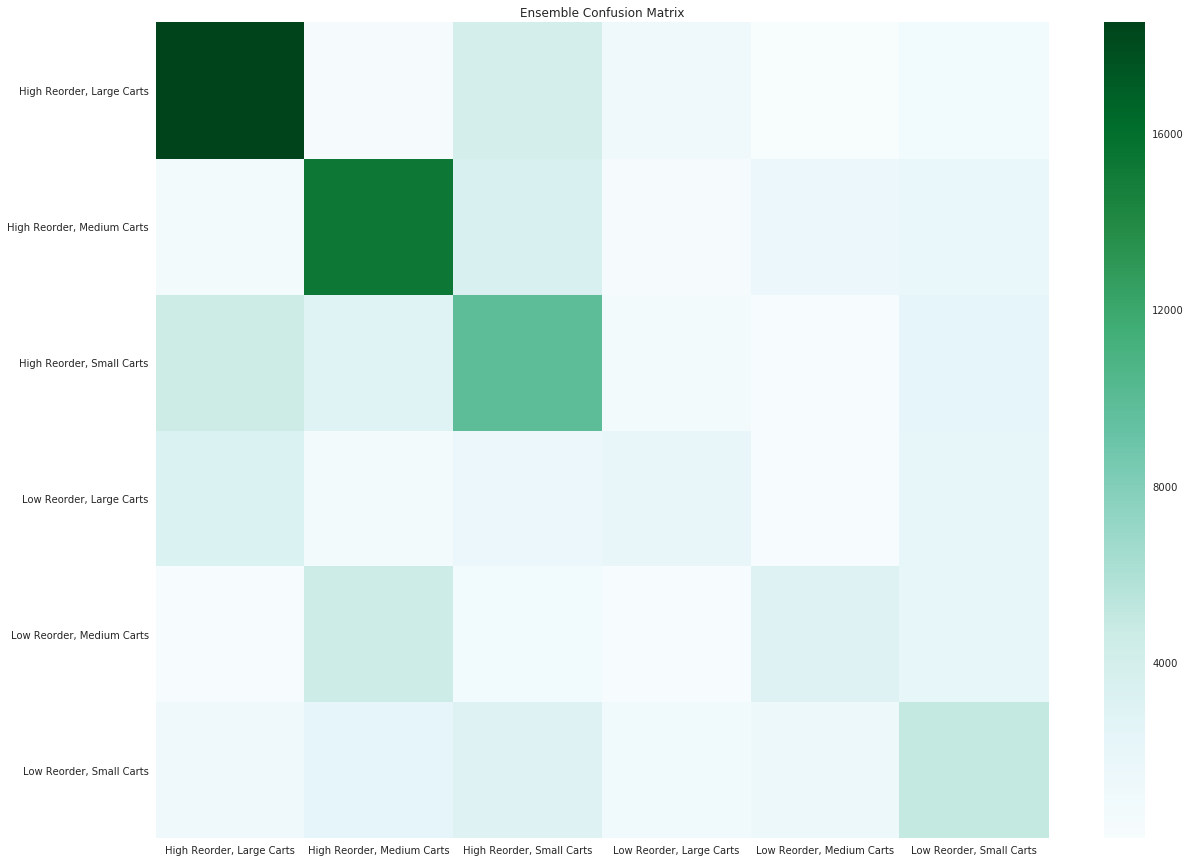

In [95]:
plt.figure(figsize = (20,15))
sns.heatmap(confusion_matrix(ys_test, eclf.predict(Xs_test)), 
            xticklabels = ['High Reorder, Large Carts', 'High Reorder, Medium Carts','High Reorder, Small Carts', 
                           'Low Reorder, Large Carts','Low Reorder, Medium Carts','Low Reorder, Small Carts',], 
            yticklabels = ['High Reorder, Large Carts', 'High Reorder, Medium Carts', 'High Reorder, Small Carts', 
                           'Low Reorder, Large Carts', 'Low Reorder, Medium Carts','Low Reorder, Small Carts',], 
            cmap = "BuGn")
plt.title("Ensemble Confusion Matrix")

In [14]:
features = zip(df_set.drop('future_class',1).columns, RFC3.feature_importances_)
features = sorted(featuresv2, key = lambda x: x[1], reverse = True)

features [:20]

[('log_total_products', 0.037994973772723067),
 ('avg_cart', 0.037564516921306634),
 ('total_products', 0.035797553773893494),
 ('log_avg_cart', 0.035067221650467932),
 ('total_reorders', 0.029133765796650078),
 ('0_streak', 0.02812944114784682),
 ('avg_reorders', 0.028081128547128662),
 ('0_reorder_ratio', 0.02779943733210602),
 ('ttl_reorder_rate', 0.027066960767508853),
 ('order_gap_std', 0.022261620608073882),
 ('order_gap_mean', 0.022090348584718138),
 ('user_id', 0.021115414688280657),
 ('hour_std', 0.020651973403800511),
 ('hour_mean', 0.01984354575540918),
 ('dow_std', 0.019790703926822341),
 ('dow_mean', 0.019459681154646909),
 ('2_streak', 0.018622985717450954),
 ('cart_size_class', 0.018327180337330308),
 ('fresh vegetables', 0.016557076944411178),
 ('3_reorder_ratio', 0.016421679234869348)]

In [4]:
df_set = pd.read_pickle('X_Scaled_upsampled')

I accidentally left in user_id - let's get rid of it.

In [16]:
df_set = df_set.drop('user_id', 1)

In [17]:
X_t = StandardScaler().fit_transform(df_set.drop(['frozen juice', 'baby accessories', 'beauty',
                                                         'baby bath body care', 'kosher foods', 'skin care', 
                                                         'bulk dried fruits vegetables', 'ice cream toppings', 
                                                         'kitchen supplies','eye ear care', 'future_class'],1))
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_t, df_set['future_class'], train_size = .3)

In [18]:
RFCt = RandomForestClassifier(n_estimators = 1000)
RFCt.fit(Xt_train, yt_train)
print(accuracy_score(yt_test, RFCt.predict(Xt_test)))
print(classification_report(yt_test, RFCt.predict(Xt_test)))

0.519828729713
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.63      0.77      0.70     24401
   high_reorder_low_avg_cart       0.59      0.66      0.62     23032
high_reorder_medium_avg_cart       0.43      0.47      0.45     20571
  low_reorder_large_avg_cart       0.39      0.18      0.24      9939
    low_reorder_low_avg_cart       0.47      0.26      0.34     10784
 low_reorder_medium_avg_cart       0.35      0.37      0.36     13801

                 avg / total       0.51      0.52      0.50    102528



In [19]:
logt = LogisticRegression(C = .01)
logt.fit(Xt_train, yt_train)
print(np.mean(cross_val_score(logt, X_t, df_set['future_class'], cv = 5, n_jobs= 2)))
print(classification_report(yt_test, logt.predict(Xt_test)))

0.521765843254
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.63      0.77      0.70     24401
   high_reorder_low_avg_cart       0.58      0.67      0.62     23032
high_reorder_medium_avg_cart       0.43      0.46      0.44     20571
  low_reorder_large_avg_cart       0.40      0.15      0.22      9939
    low_reorder_low_avg_cart       0.47      0.27      0.34     10784
 low_reorder_medium_avg_cart       0.35      0.36      0.36     13801

                 avg / total       0.50      0.52      0.50    102528



In [24]:
X_s = StandardScaler().fit_transform(df_set.drop(['future_class'],1))
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_s, df_set['future_class'], train_size = .3)


In [25]:
RFCs = RandomForestClassifier(n_estimators = 1000)
RFCs.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, RFCs.predict(Xs_test)))
print(classification_report(ys_test, RFCs.predict(Xs_test)))

0.520960127965
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.64      0.76      0.70     24593
   high_reorder_low_avg_cart       0.59      0.65      0.62     23000
high_reorder_medium_avg_cart       0.43      0.49      0.46     20437
  low_reorder_large_avg_cart       0.38      0.19      0.25      9832
    low_reorder_low_avg_cart       0.47      0.26      0.33     10840
 low_reorder_medium_avg_cart       0.36      0.37      0.36     13826

                 avg / total       0.51      0.52      0.51    102528



In [26]:
logs = LogisticRegression(C = .01)
logs.fit(Xs_train, ys_train)
print(np.mean(cross_val_score(logs, X_s, df_set['future_class'], cv = 5, n_jobs= 2)))
print(classification_report(ys_test, logs.predict(Xs_test)))

0.521465458154
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.65      0.76      0.70     24593
   high_reorder_low_avg_cart       0.58      0.67      0.62     23000
high_reorder_medium_avg_cart       0.42      0.48      0.45     20437
  low_reorder_large_avg_cart       0.39      0.16      0.23      9832
    low_reorder_low_avg_cart       0.48      0.27      0.34     10840
 low_reorder_medium_avg_cart       0.36      0.35      0.35     13826

                 avg / total       0.50      0.52      0.50    102528



In [27]:
gbcs = GradientBoostingClassifier()
gbcs.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, gbcs.predict(Xs_test)))
print(classification_report(ys_test, gbcs.predict(Xs_test)))

0.521984238452
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.66      0.74      0.70     24593
   high_reorder_low_avg_cart       0.60      0.65      0.62     23000
high_reorder_medium_avg_cart       0.43      0.50      0.46     20437
  low_reorder_large_avg_cart       0.37      0.21      0.27      9832
    low_reorder_low_avg_cart       0.47      0.28      0.35     10840
 low_reorder_medium_avg_cart       0.35      0.37      0.36     13826

                 avg / total       0.51      0.52      0.51    102528



In [28]:
adcs = AdaBoostClassifier()
adcs.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, adcs.predict(Xs_test)))
print(classification_report(ys_test, adcs.predict(Xs_test)))

0.507646691635
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.64      0.74      0.69     24593
   high_reorder_low_avg_cart       0.61      0.59      0.60     23000
high_reorder_medium_avg_cart       0.42      0.47      0.44     20437
  low_reorder_large_avg_cart       0.32      0.23      0.27      9832
    low_reorder_low_avg_cart       0.43      0.34      0.38     10840
 low_reorder_medium_avg_cart       0.35      0.35      0.35     13826

                 avg / total       0.50      0.51      0.50    102528



In [29]:
eclf = VotingClassifier(estimators=[('gbc', gbcs), ('abc', adcs), ('rfc', RFCs), ('log', logs)], 
                        voting='hard')

eclf.fit(Xs_train, ys_train)
print(accuracy_score(ys_test, eclf.predict(Xs_test)))
print(classification_report(ys_test, eclf.predict(Xs_test)))

0.522140293383
                              precision    recall  f1-score   support

 high_reorder_large_avg_cart       0.64      0.77      0.70     24593
   high_reorder_low_avg_cart       0.59      0.67      0.63     23000
high_reorder_medium_avg_cart       0.43      0.48      0.45     20437
  low_reorder_large_avg_cart       0.37      0.18      0.24      9832
    low_reorder_low_avg_cart       0.48      0.27      0.34     10840
 low_reorder_medium_avg_cart       0.36      0.34      0.35     13826

                 avg / total       0.51      0.52      0.51    102528



In [30]:
featuresv2 = zip(df_set.drop('future_class',1).columns, RFCs.feature_importances_)
featuresv2 = sorted(featuresv2, key = lambda x: x[1], reverse = True)

featuresv2 [:20]

[('total_products', 0.037375160706120028),
 ('log_avg_cart', 0.036851235412701473),
 ('log_total_products', 0.03660550670831314),
 ('avg_cart', 0.03524323925946897),
 ('total_reorders', 0.02941331770913419),
 ('avg_reorders', 0.028127909200436178),
 ('0_streak', 0.028086573617823685),
 ('ttl_reorder_rate', 0.027818324044682985),
 ('0_reorder_ratio', 0.027622211691035757),
 ('order_gap_mean', 0.023087827172550618),
 ('order_gap_std', 0.022921009475690667),
 ('hour_std', 0.021296408123562326),
 ('hour_mean', 0.020641275214875521),
 ('dow_std', 0.020581338506854185),
 ('dow_mean', 0.019968019775279545),
 ('2_streak', 0.019529034584410285),
 ('cart_size_class', 0.017864597729067549),
 ('fresh fruits', 0.017069954687309142),
 ('fresh vegetables', 0.016720980197895537),
 ('3_reorder_ratio', 0.016575294231530362)]